In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import npts

## Download data 

In [2]:
# from urllib.request import urlretrieve, HTTPError
# URL_BASE = 'https://docs.misoenergy.org/marketreports/'
DATA_DIR = 'data/'

# for year in range(2011, 2019):
#     for month_start, month_end in [['Jan', 'Mar'], 
#                                    ['Apr', 'Jun'],
#                                    ['Jul', 'Sep'],
#                                    ['Oct', 'Dec']]:
#         tentative_fname = f'{year}_{month_start}-{month_end}_RT_LMPs.zip'
#         try:
#             print(f'downloading {URL_BASE + tentative_fname}')
#             urlretrieve(URL_BASE + tentative_fname, DATA_DIR + tentative_fname)
#         except HTTPError:
#             print('HTTP 404 - file not found.')

## Extract single node LMPs time series

In [3]:
# # consider changing the data storage format, this is time consuming
CHOSEN_NODE = 'AEC'
# result = pd.Series()
# for year in range(2011, 2019):
#     for month_start, month_end in [['Jan', 'Mar'], 
#                                    ['Apr', 'Jun'],
#                                    ['Jul', 'Sep'],
#                                    ['Oct', 'Dec']]:
#         tentative_fname = f'{year}_{month_start}-{month_end}_RT_LMPs.zip'
#         try:
#             print(f'processing {DATA_DIR + tentative_fname}')
#             df = pd.read_csv(DATA_DIR + tentative_fname, index_col = 0, parse_dates = [0])
#             as_series = df[(df.NODE==CHOSEN_NODE)&(df.VALUE=='LMP')].iloc[:,3:].T.unstack()
#             as_series.index = \
#                 [day + pd.Timedelta(f'{hour[2:]}H') for day, hour in as_series.index]
#             result = pd.concat((result, as_series))
#             print(f'new result series length: {len(result)}')
#         except IOError:
#             print('file not found.')
            
# result.to_csv(DATA_DIR+f'{CHOSEN_NODE}_LMPs_aggregate.csv')

In [4]:
result = pd.read_csv(DATA_DIR+f'{CHOSEN_NODE}_LMPs_aggregate.csv', 
                     index_col = 0, parse_dates=[0], header=None)
result = result.iloc[:,0]

### Look at data 

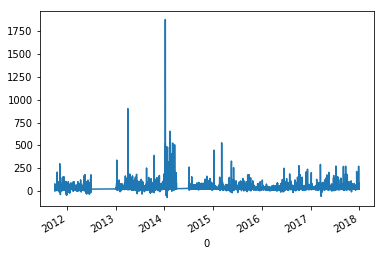

In [5]:
result.plot()

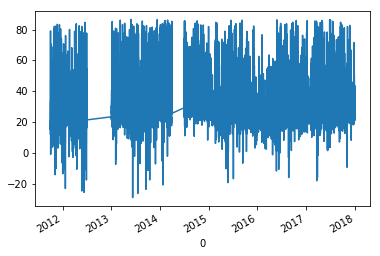

In [8]:
def remove_outliers(data):
    mean, std = data.mean(), data.std()
    no_outliers = data[(data > mean - 3*std) &(data < mean + 3*std)]
    return no_outliers

data_no_outliers = remove_outliers(result)

data_no_outliers.plot()

data_used = data_no_outliers[:-len(data_no_outliers)//5]
indep_test = data_no_outliers[-len(data_no_outliers)//5:]

In [12]:
bas = npts.Baseline(verbose=True)
bas.fit(data_used, train_frac=1.)

Building baseline with 1 =   values.
building reg matrices
Fitting on 38136 observations, of dimension 1
Train set: 38136 obs. Test set : 0 obs.
Making quadratic loss term for 38136 obs.
Making quadratic loss term for 0 obs.
Provided lambdas: []
working with lambda ()
solving with λ=()
CG took 0.00017786026000976562 seconds.
Val. cost: 0.000e+00
Best λ = ()


In [13]:
data_used.mean()

27.125872404027692

In [14]:
bas.theta

array([[ 27.1258724]])

In [ ]:
import time

def constant_model(data, test):
    s = time.time()
    mean = np.mean(data)
    took_time = time.time() - s
    return rmse_from_residuals(test - mean), took_time

def rmse_from_residuals(res):
    assert sum(np.isnan(res)) == 0.
    return np.sqrt(np.mean(res**2))

def model_test_rmse(model, test):
    pred = model.predict(test.index)
    res = test - pred
    return rmse_from_residuals(res)
    
def daily_avg_model(data, test):
    s = time.time()
    #model = npts.Baseline(npts.HourOfDay(lambdas=[1E-6]))
    #model.fit(data, train_frac=1)
    model = data.groupby(data.index.hour).mean()
    took_time = time.time() - s
    res = test - model[test.index.hour].values
    res = res.fillna(method='pad').fillna(method='backfill')
    #rmse = model_test_rmse(model, test)
    return rmse_from_residuals(res), took_time

def annual_avg_model(data, test):
    s = time.time()
    model = data.groupby(data.index.dayofyear).mean()
    #model = npts.Baseline(npts.DayOfYear(lambdas=[1E-6]))
    #model.fit(data, train_frac=1)
    took_time = time.time() - s
    res = test - model[test.index.dayofyear].values
    res = res.fillna(method='pad').fillna(method='backfill')
    #rmse = model_test_rmse(model, test)
    return rmse_from_residuals(res), took_time

def daily_annual_avg_model(data, test):
    s = time.time()
#     model = npts.Baseline(npts.HourOfDay(lambdas=[1E-6]),
#                           npts.DayOfYear(lambdas=[1E-6]))
#     model.fit(data, train_frac=1)
    model = data.groupby((data.index.hour, data.index.dayofyear)).mean()
    took_time = time.time() - s
    res = test - model[zip(test.index.hour, test.index.dayofyear)].values
    res = res.fillna(method='pad').fillna(method='backfill')
    #rmse = model_test_rmse(model, test)
    return rmse_from_residuals(res), took_time

def daily_annual_bas_model(data, test):
    s = time.time()
    model = npts.Baseline(npts.HourOfDay(lambdas=np.logspace(-6,2, 20)),
                          npts.DayOfYear(lambdas=np.logspace(-6,2, 20)))
    model.fit(data)
    took_time = time.time() - s
    return model_test_rmse(model, test), took_time



In [ ]:
%debug

> /Users/enzo/anaconda3/envs/pytimeseries-env/lib/python3.6/site-packages/scipy/sparse/coo.py(196)getnnz()
    194         if axis is None:
    195             nnz = len(self.data)
--> 196             if nnz != len(self.row) or nnz != len(self.col):
    197                 raise ValueError('row, column, and data array must all be the '
    198                                  'same length')

ipdb> u
> /Users/enzo/anaconda3/envs/pytimeseries-env/lib/python3.6/site-packages/scipy/sparse/base.py(221)nnz()
    219         count_nonzero : Number of non-zero entries
    220         """
--> 221         return self.getnnz()
    222 
    223     def getformat(self):

ipdb> u
> /Users/enzo/anaconda3/envs/pytimeseries-env/lib/python3.6/site-packages/scipy/sparse/coo.py(235)_check()
    233         self.data = to_native(self.data)
    234 
--> 235         if self.nnz > 0:
    236             if self.row.max() >= self.shape[0]:
    237                 raise ValueError('row index exceeds matrix dime

In [155]:
import time

def constant_model(data, test):
    s = time.time()
    mean = np.mean(remove_outliers(data))
    took_time = time.time() - s
    rmse = np.sqrt(np.mean((test - mean)**2))
    return rmse, took_time

def rmse_from_residuals(res):
    assert sum(np.isnan(res)) == 0.
    return np.sqrt(np.mean(res**2))

def model_test_rmse(model, test):
    pred = model.predict(test.index)
    res = test - pred
    return rmse_from_residuals(res)
    
def daily_avg_model(data, test):
    #used_data = remove_outliers(data)
    used_data=data
    s = time.time()
    #model = npts.Baseline(npts.HourOfDay(lambdas=[1E-6]))
    #model.fit(data, train_frac=1)
    model = used_data.groupby(used_data.index.hour).mean()
    took_time = time.time() - s
    res = test - model[test.index.hour].values
    res = res.fillna(method='pad').fillna(method='backfill')
    #rmse = model_test_rmse(model, test)
    return rmse_from_residuals(res), took_time

def weekly_avg_model(data, test):
    #used_data = remove_outliers(data)
    used_data=data
    s = time.time()
    #model = npts.Baseline(npts.HourOfDay(lambdas=[1E-6]))
    #model.fit(data, train_frac=1)
    model = used_data.groupby(used_data.index.dayofweek).mean()
    took_time = time.time() - s
    res = test - model[test.index.dayofweek].values
    res = res.fillna(method='pad').fillna(method='backfill')
    #rmse = model_test_rmse(model, test)
    return rmse_from_residuals(res), took_time

def annual_avg_model(data, test):
    #used_data = remove_outliers(data)
    used_data=data
    s = time.time()
    model = used_data.groupby(used_data.index.dayofyear).mean()
    #model = npts.Baseline(npts.DayOfYear(lambdas=[1E-6]))
    #model.fit(data, train_frac=1)
    took_time = time.time() - s
    res = test - model[test.index.dayofyear].values
    res = res.fillna(method='pad').fillna(method='backfill')
    #rmse = model_test_rmse(model, test)
    return rmse_from_residuals(res), took_time

# def daily_annual_avg_model(data, test):
#     s = time.time()
# #     model = npts.Baseline(npts.HourOfDay(lambdas=[1E-6]),
# #                           npts.DayOfYear(lambdas=[1E-6]))
# #     model.fit(data, train_frac=1)
#     model = data.groupby((data.index.hour, data.index.dayofyear)).mean()
#     took_time = time.time() - s
#     res = test - model[zip(test.index.hour, test.index.dayofyear)].values
#     res = res.fillna(method='pad').fillna(method='backfill')
#     assert sum(np.isnan(res)) == 0.
#     rmse = np.sqrt((res**2).mean(skipna=False))
#     #rmse = model_test_rmse(model, test)
#     return rmse, took_time

def daily_weekly_bas_model(data, test):
    s = time.time()
    model = npts.Baseline(npts.HourOfDay(lambdas=np.logspace(-6,2, 5)),
                          #npts.MonthOfYear(lambdas=np.logspace(-6,2, 5)),
                         npts.DayOfWeek(lambdas=np.logspace(-6,2, 5)),
                          verbose=True)
    #model.fit(remove_outliers(data))
    model.fit(data)
    took_time = time.time() - s
    return model_test_rmse(model, test), took_time

def daily_annual_weekly_bas_model(data, test):
    s = time.time()
    model = npts.Baseline(npts.HourOfDay(lambdas=np.logspace(-6,2, 5)),
                          npts.MonthOfYear(lambdas=np.logspace(-6,2, 5)),
                         npts.DayOfWeek(lambdas=np.logspace(-6,2, 5)),
                          verbose=True)
    #model.fit(remove_outliers(data))
    model.fit(data)
    took_time = time.time() - s
    return model_test_rmse(model, test), took_time


In [161]:
np.random.seed(0)
indep_test_rmse = pd.DataFrame()
time_taken_df = pd.DataFrame()

for data, dataname in [(data_used, '100% data'), 
                       #(data_used[np.random.uniform(size=len(data_used)) < .5], '50% data'),
                      (data_used[np.random.uniform(size=len(data_used)) < .1], '10% data'),
                      # (data_used[np.random.uniform(size=len(data_used)) < .05], '5% data'),
                      (data_used[np.random.uniform(size=len(data_used)) < .01], '1% data'),
                      # (data_used[np.random.uniform(size=len(data_used)) < .005], '0.5% data'),
                      #(data_used[np.random.uniform(size=len(data_used)) < .001], '0.1% data'),
                      ]:
    for model, modelname in [(constant_model, 'constant'), 
                             (daily_avg_model, 'hour avg.'),
                            (annual_avg_model, 'day-of-year avg.'),
                             (weekly_avg_model, 'day-of-week avg.'), 
                            #(daily_annual_avg_model, 'hour and day-of-year avg.'),
                            (daily_weekly_bas_model, 'hour and day-of-week baseline'),
                            (daily_annual_weekly_bas_model, 'month-of-year and hour and day-of-week baseline')
                            ]:
        rmse, time_taken = model(data, indep_test)
        indep_test_rmse.loc[dataname, modelname] = rmse
        time_taken_df.loc[dataname, modelname] = time_taken

/Users/enzo/anaconda3/envs/pytimeseries-env/lib/python3.6/site-packages/pandas/core/series.py:696: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


Building baseline with 168 =  24*7 values.
building reg matrices
Fitting on 38136 observations, of dimension 1
Train set: 30565 obs. Test set : 7571 obs.
Making quadratic loss term for 30565 obs.
Making quadratic loss term for 7571 obs.
Provided lambdas: [array([  1.00000000e-06,   1.00000000e-04,   1.00000000e-02,
         1.00000000e+00,   1.00000000e+02]), array([  1.00000000e-06,   1.00000000e-04,   1.00000000e-02,
         1.00000000e+00,   1.00000000e+02])]
working with lambda (9.9999999999999995e-07, 9.9999999999999995e-07)
solving with λ=(9.9999999999999995e-07, 9.9999999999999995e-07)
CG took 0.0002930164337158203 seconds.
Val. cost: 8.926e+01
working with lambda (9.9999999999999995e-07, 0.0001)
solving with λ=(9.9999999999999995e-07, 0.0001)
CG took 0.0003192424774169922 seconds.
Val. cost: 8.920e+01
working with lambda (9.9999999999999995e-07, 0.01)
solving with λ=(9.9999999999999995e-07, 0.01)
CG took 0.0006761550903320312 seconds.
Val. cost: 8.929e+01
working with lambda (

CG took 0.002895832061767578 seconds.
Val. cost: 8.894e+01
working with lambda (0.0001, 1.0, 0.0001)
solving with λ=(0.0001, 1.0, 0.0001)
CG took 0.003062009811401367 seconds.
Val. cost: 8.881e+01
working with lambda (0.0001, 1.0, 0.01)
solving with λ=(0.0001, 1.0, 0.01)
CG took 0.005674123764038086 seconds.
Val. cost: 8.997e+01
working with lambda (0.0001, 1.0, 1.0)
solving with λ=(0.0001, 1.0, 1.0)
CG took 0.0027818679809570312 seconds.
Val. cost: 9.012e+01
working with lambda (0.0001, 1.0, 100.0)
solving with λ=(0.0001, 1.0, 100.0)
CG took 0.00092315673828125 seconds.
Val. cost: 9.012e+01
working with lambda (0.0001, 100.0, 9.9999999999999995e-07)
solving with λ=(0.0001, 100.0, 9.9999999999999995e-07)
CG took 0.0034530162811279297 seconds.
Val. cost: 8.897e+01
working with lambda (0.0001, 100.0, 0.0001)
solving with λ=(0.0001, 100.0, 0.0001)
CG took 0.002563953399658203 seconds.
Val. cost: 8.884e+01
working with lambda (0.0001, 100.0, 0.01)
solving with λ=(0.0001, 100.0, 0.01)
CG to

CG took 0.012748003005981445 seconds.
Val. cost: 1.042e+02
working with lambda (1.0, 100.0, 0.01)
solving with λ=(1.0, 100.0, 0.01)
CG took 0.028744935989379883 seconds.
Val. cost: 1.047e+02
working with lambda (1.0, 100.0, 1.0)
solving with λ=(1.0, 100.0, 1.0)
CG took 0.009699106216430664 seconds.
Val. cost: 1.048e+02
working with lambda (1.0, 100.0, 100.0)
solving with λ=(1.0, 100.0, 100.0)
CG took 0.0009698867797851562 seconds.
Val. cost: 1.048e+02
working with lambda (100.0, 9.9999999999999995e-07, 9.9999999999999995e-07)
solving with λ=(100.0, 9.9999999999999995e-07, 9.9999999999999995e-07)
CG took 0.003312826156616211 seconds.
Val. cost: 1.024e+02
working with lambda (100.0, 9.9999999999999995e-07, 0.0001)
solving with λ=(100.0, 9.9999999999999995e-07, 0.0001)
CG took 0.0030798912048339844 seconds.
Val. cost: 1.023e+02
working with lambda (100.0, 9.9999999999999995e-07, 0.01)
solving with λ=(100.0, 9.9999999999999995e-07, 0.01)
CG took 0.00701594352722168 seconds.
Val. cost: 1.03

CG took 0.002343893051147461 seconds.
Val. cost: 7.348e+01
working with lambda (0.0001, 0.0001, 1.0)
solving with λ=(0.0001, 0.0001, 1.0)
CG took 0.0016930103302001953 seconds.
Val. cost: 7.334e+01
working with lambda (0.0001, 0.0001, 100.0)
solving with λ=(0.0001, 0.0001, 100.0)
CG took 0.0007259845733642578 seconds.
Val. cost: 7.334e+01
working with lambda (0.0001, 0.01, 9.9999999999999995e-07)
solving with λ=(0.0001, 0.01, 9.9999999999999995e-07)
CG took 0.0025098323822021484 seconds.
Val. cost: 7.879e+01
working with lambda (0.0001, 0.01, 0.0001)
solving with λ=(0.0001, 0.01, 0.0001)
CG took 0.001583099365234375 seconds.
Val. cost: 7.731e+01
working with lambda (0.0001, 0.01, 0.01)
solving with λ=(0.0001, 0.01, 0.01)
CG took 0.002218961715698242 seconds.
Val. cost: 7.727e+01
working with lambda (0.0001, 0.01, 1.0)
solving with λ=(0.0001, 0.01, 1.0)
CG took 0.0034852027893066406 seconds.
Val. cost: 7.735e+01
working with lambda (0.0001, 0.01, 100.0)
solving with λ=(0.0001, 0.01, 100

CG took 0.007208824157714844 seconds.
Val. cost: 9.255e+01
working with lambda (1.0, 1.0, 0.0001)
solving with λ=(1.0, 1.0, 0.0001)
CG took 0.004996776580810547 seconds.
Val. cost: 9.205e+01
working with lambda (1.0, 1.0, 0.01)
solving with λ=(1.0, 1.0, 0.01)
CG took 0.0076427459716796875 seconds.
Val. cost: 9.197e+01
working with lambda (1.0, 1.0, 1.0)
solving with λ=(1.0, 1.0, 1.0)
CG took 0.0032041072845458984 seconds.
Val. cost: 9.202e+01
working with lambda (1.0, 1.0, 100.0)
solving with λ=(1.0, 1.0, 100.0)
CG took 0.0028150081634521484 seconds.
Val. cost: 9.202e+01
working with lambda (1.0, 100.0, 9.9999999999999995e-07)
solving with λ=(1.0, 100.0, 9.9999999999999995e-07)
CG took 0.021644115447998047 seconds.
Val. cost: 9.257e+01
working with lambda (1.0, 100.0, 0.0001)
solving with λ=(1.0, 100.0, 0.0001)
CG took 0.016239166259765625 seconds.
Val. cost: 9.207e+01
working with lambda (1.0, 100.0, 0.01)
solving with λ=(1.0, 100.0, 0.01)
CG took 0.024951696395874023 seconds.
Val. co

CG took 0.00790715217590332 seconds.
Val. cost: 8.291e+01
working with lambda (9.9999999999999995e-07, 1.0, 1.0)
solving with λ=(9.9999999999999995e-07, 1.0, 1.0)
CG took 0.004019975662231445 seconds.
Val. cost: 8.268e+01
working with lambda (9.9999999999999995e-07, 1.0, 100.0)
solving with λ=(9.9999999999999995e-07, 1.0, 100.0)
CG took 0.0030961036682128906 seconds.
Val. cost: 8.269e+01
working with lambda (9.9999999999999995e-07, 100.0, 9.9999999999999995e-07)
solving with λ=(9.9999999999999995e-07, 100.0, 9.9999999999999995e-07)
CG took 0.006114006042480469 seconds.
Val. cost: 9.487e+01
working with lambda (9.9999999999999995e-07, 100.0, 0.0001)
solving with λ=(9.9999999999999995e-07, 100.0, 0.0001)
CG took 0.00603795051574707 seconds.
Val. cost: 9.416e+01
working with lambda (9.9999999999999995e-07, 100.0, 0.01)
solving with λ=(9.9999999999999995e-07, 100.0, 0.01)
CG took 0.00896000862121582 seconds.
Val. cost: 8.297e+01
working with lambda (9.9999999999999995e-07, 100.0, 1.0)
solv

CG took 0.01298379898071289 seconds.
Val. cost: 7.969e+01
working with lambda (0.01, 100.0, 1.0)
solving with λ=(0.01, 100.0, 1.0)
CG took 0.01704716682434082 seconds.
Val. cost: 7.963e+01
working with lambda (0.01, 100.0, 100.0)
solving with λ=(0.01, 100.0, 100.0)
CG took 0.00442814826965332 seconds.
Val. cost: 7.963e+01
working with lambda (1.0, 9.9999999999999995e-07, 9.9999999999999995e-07)
solving with λ=(1.0, 9.9999999999999995e-07, 9.9999999999999995e-07)
CG took 0.012542963027954102 seconds.
Val. cost: 8.941e+01
working with lambda (1.0, 9.9999999999999995e-07, 0.0001)
solving with λ=(1.0, 9.9999999999999995e-07, 0.0001)
CG took 0.007950067520141602 seconds.
Val. cost: 8.374e+01
working with lambda (1.0, 9.9999999999999995e-07, 0.01)
solving with λ=(1.0, 9.9999999999999995e-07, 0.01)
CG took 0.013607978820800781 seconds.
Val. cost: 8.677e+01
working with lambda (1.0, 9.9999999999999995e-07, 1.0)
solving with λ=(1.0, 9.9999999999999995e-07, 1.0)
CG took 0.004988193511962891 seco

In [162]:
indep_test_rmse

,constant,hour avg.,day-of-year avg.,day-of-week avg.,hour and day-of-week baseline,month-of-year and hour and day-of-week baseline
100% data,9.030346,7.988799,9.334015,8.923480,7.914045,7.656062
10% data,9.008122,8.041212,10.124395,8.928413,7.948377,7.966700
1% data,9.135144,8.413696,11.742678,9.096881,8.199067,8.178125


### Test

In [201]:
# result_no_outliers = result[(result > result.mean() - 3*result.std()) &
#                            (result < result.mean() + 3*result.std())]

In [125]:
# # train = result[:-len(result_no_outliers)//5]
# # test = result[-len(result_no_outliers)//5:]

# train = result_no_outliers[:-len(result_no_outliers)//5]
# test = result_no_outliers[-len(result_no_outliers)//5:]

In [202]:
# train.plot()

In [56]:
def weekly_avg_model(data, test):
    used_data = remove_outliers(data)
    s = time.time()
    #model = npts.Baseline(npts.HourOfDay(lambdas=[1E-6]))
    #model.fit(data, train_frac=1)
    model = used_data.groupby(used_data.index.dayofweek).mean()
    print(model)
    took_time = time.time() - s
    res = test - model[test.index.dayofweek].values
    #res = res.fillna(method='pad').fillna(method='backfill')
    assert sum(np.isnan(res)) == 0.
    rmse = np.sqrt((res**2).mean(skipna=False))
    #rmse = model_test_rmse(model, test)
    return rmse, took_time

In [57]:
weekly_avg_model(data_used, indep_test)

0
0    26.857193
1    26.431098
2    26.778906
3    26.839545
4    26.339419
5    25.688247
6    24.650111
Name: 1, dtype: float64


(8.9818924699520242, 0.006154060363769531)

In [150]:
mask = np.random.uniform(size=len(data_used)) < .1

baseline=npts.Baseline(npts.MonthOfYear(lambdas=np.logspace(-6,2,10)),
                       npts.DayOfWeek(lambdas=np.logspace(-6,2,10)),
                       npts.HourOfDay(lambdas=np.logspace(-6,2,10)),
                        verbose=True)
baseline.fit(data_used[mask])

Building baseline with 2016 =  12*7*24 values.
building reg matrices
Fitting on 3905 observations, of dimension 1
Train set: 3098 obs. Test set : 807 obs.
Making quadratic loss term for 3098 obs.
Making quadratic loss term for 807 obs.
Provided lambdas: [array([  1.00000000e-06,   7.74263683e-06,   5.99484250e-05,
         4.64158883e-04,   3.59381366e-03,   2.78255940e-02,
         2.15443469e-01,   1.66810054e+00,   1.29154967e+01,
         1.00000000e+02]), array([  1.00000000e-06,   7.74263683e-06,   5.99484250e-05,
         4.64158883e-04,   3.59381366e-03,   2.78255940e-02,
         2.15443469e-01,   1.66810054e+00,   1.29154967e+01,
         1.00000000e+02]), array([  1.00000000e-06,   7.74263683e-06,   5.99484250e-05,
         4.64158883e-04,   3.59381366e-03,   2.78255940e-02,
         2.15443469e-01,   1.66810054e+00,   1.29154967e+01,
         1.00000000e+02])]
working with lambda (9.9999999999999995e-07, 9.9999999999999995e-07, 9.9999999999999995e-07)
solving with λ=(9.9999

CG took 0.00653529167175293 seconds.
Val. cost: 8.084e+01
working with lambda (9.9999999999999995e-07, 0.21544346900318823, 0.21544346900318823)
solving with λ=(9.9999999999999995e-07, 0.21544346900318823, 0.21544346900318823)
CG took 0.003748178482055664 seconds.
Val. cost: 8.599e+01
working with lambda (9.9999999999999995e-07, 0.21544346900318823, 1.6681005372000557)
solving with λ=(9.9999999999999995e-07, 0.21544346900318823, 1.6681005372000557)
CG took 0.003972053527832031 seconds.
Val. cost: 8.690e+01
working with lambda (9.9999999999999995e-07, 0.21544346900318823, 12.915496650148826)
solving with λ=(9.9999999999999995e-07, 0.21544346900318823, 12.915496650148826)
CG took 0.003710031509399414 seconds.
Val. cost: 8.702e+01
working with lambda (9.9999999999999995e-07, 0.21544346900318823, 100.0)
solving with λ=(9.9999999999999995e-07, 0.21544346900318823, 100.0)
CG took 0.002936840057373047 seconds.
Val. cost: 8.704e+01
working with lambda (9.9999999999999995e-07, 1.668100537200055

CG took 0.003056049346923828 seconds.
Val. cost: 7.212e+01
working with lambda (7.7426368268112769e-06, 0.0035938136638046258, 0.02782559402207126)
solving with λ=(7.7426368268112769e-06, 0.0035938136638046258, 0.02782559402207126)
CG took 0.0036220550537109375 seconds.
Val. cost: 8.104e+01
working with lambda (7.7426368268112769e-06, 0.0035938136638046258, 0.21544346900318823)
solving with λ=(7.7426368268112769e-06, 0.0035938136638046258, 0.21544346900318823)
CG took 0.004586935043334961 seconds.
Val. cost: 8.601e+01
working with lambda (7.7426368268112769e-06, 0.0035938136638046258, 1.6681005372000557)
solving with λ=(7.7426368268112769e-06, 0.0035938136638046258, 1.6681005372000557)
CG took 0.006196022033691406 seconds.
Val. cost: 8.690e+01
working with lambda (7.7426368268112769e-06, 0.0035938136638046258, 12.915496650148826)
solving with λ=(7.7426368268112769e-06, 0.0035938136638046258, 12.915496650148826)
CG took 0.004420042037963867 seconds.
Val. cost: 8.702e+01
working with lam

CG took 0.0018589496612548828 seconds.
Val. cost: 1.050e+02
working with lambda (5.9948425031894089e-05, 7.7426368268112769e-06, 7.7426368268112769e-06)
solving with λ=(5.9948425031894089e-05, 7.7426368268112769e-06, 7.7426368268112769e-06)
CG took 0.0015497207641601562 seconds.
Val. cost: 1.024e+02
working with lambda (5.9948425031894089e-05, 7.7426368268112769e-06, 5.9948425031894089e-05)
solving with λ=(5.9948425031894089e-05, 7.7426368268112769e-06, 5.9948425031894089e-05)
CG took 0.0010440349578857422 seconds.
Val. cost: 9.308e+01
working with lambda (5.9948425031894089e-05, 7.7426368268112769e-06, 0.00046415888336127773)
solving with λ=(5.9948425031894089e-05, 7.7426368268112769e-06, 0.00046415888336127773)
CG took 0.001110076904296875 seconds.
Val. cost: 8.019e+01
working with lambda (5.9948425031894089e-05, 7.7426368268112769e-06, 0.0035938136638046258)
solving with λ=(5.9948425031894089e-05, 7.7426368268112769e-06, 0.0035938136638046258)
CG took 0.0018000602722167969 seconds.


CG took 0.0045299530029296875 seconds.
Val. cost: 8.083e+01
working with lambda (5.9948425031894089e-05, 0.02782559402207126, 0.21544346900318823)
solving with λ=(5.9948425031894089e-05, 0.02782559402207126, 0.21544346900318823)
CG took 0.004273891448974609 seconds.
Val. cost: 8.592e+01
working with lambda (5.9948425031894089e-05, 0.02782559402207126, 1.6681005372000557)
solving with λ=(5.9948425031894089e-05, 0.02782559402207126, 1.6681005372000557)
CG took 0.005308866500854492 seconds.
Val. cost: 8.682e+01
working with lambda (5.9948425031894089e-05, 0.02782559402207126, 12.915496650148826)
solving with λ=(5.9948425031894089e-05, 0.02782559402207126, 12.915496650148826)
CG took 0.005055904388427734 seconds.
Val. cost: 8.694e+01
working with lambda (5.9948425031894089e-05, 0.02782559402207126, 100.0)
solving with λ=(5.9948425031894089e-05, 0.02782559402207126, 100.0)
CG took 0.002817869186401367 seconds.
Val. cost: 8.696e+01
working with lambda (5.9948425031894089e-05, 0.2154434690031

CG took 0.0054378509521484375 seconds.
Val. cost: 8.699e+01
working with lambda (0.00046415888336127773, 5.9948425031894089e-05, 1.6681005372000557)
solving with λ=(0.00046415888336127773, 5.9948425031894089e-05, 1.6681005372000557)
CG took 0.004090070724487305 seconds.
Val. cost: 8.790e+01
working with lambda (0.00046415888336127773, 5.9948425031894089e-05, 12.915496650148826)
solving with λ=(0.00046415888336127773, 5.9948425031894089e-05, 12.915496650148826)
CG took 0.002741098403930664 seconds.
Val. cost: 8.802e+01
working with lambda (0.00046415888336127773, 5.9948425031894089e-05, 100.0)
solving with λ=(0.00046415888336127773, 5.9948425031894089e-05, 100.0)
CG took 0.0014147758483886719 seconds.
Val. cost: 8.804e+01
working with lambda (0.00046415888336127773, 0.00046415888336127773, 9.9999999999999995e-07)
solving with λ=(0.00046415888336127773, 0.00046415888336127773, 9.9999999999999995e-07)
CG took 0.00162506103515625 seconds.
Val. cost: 7.532e+01
working with lambda (0.0004641

CG took 0.006096839904785156 seconds.
Val. cost: 7.215e+01
working with lambda (0.00046415888336127773, 0.21544346900318823, 0.02782559402207126)
solving with λ=(0.00046415888336127773, 0.21544346900318823, 0.02782559402207126)
CG took 0.00826120376586914 seconds.
Val. cost: 8.113e+01
working with lambda (0.00046415888336127773, 0.21544346900318823, 0.21544346900318823)
solving with λ=(0.00046415888336127773, 0.21544346900318823, 0.21544346900318823)
CG took 0.00664210319519043 seconds.
Val. cost: 8.622e+01
working with lambda (0.00046415888336127773, 0.21544346900318823, 1.6681005372000557)
solving with λ=(0.00046415888336127773, 0.21544346900318823, 1.6681005372000557)
CG took 0.005303144454956055 seconds.
Val. cost: 8.714e+01
working with lambda (0.00046415888336127773, 0.21544346900318823, 12.915496650148826)
solving with λ=(0.00046415888336127773, 0.21544346900318823, 12.915496650148826)
CG took 0.005457162857055664 seconds.
Val. cost: 8.726e+01
working with lambda (0.000464158883

CG took 0.0037870407104492188 seconds.
Val. cost: 8.901e+01
working with lambda (0.0035938136638046258, 5.9948425031894089e-05, 9.9999999999999995e-07)
solving with λ=(0.0035938136638046258, 5.9948425031894089e-05, 9.9999999999999995e-07)
CG took 0.002354145050048828 seconds.
Val. cost: 7.934e+01
working with lambda (0.0035938136638046258, 5.9948425031894089e-05, 7.7426368268112769e-06)
solving with λ=(0.0035938136638046258, 5.9948425031894089e-05, 7.7426368268112769e-06)
CG took 0.0015327930450439453 seconds.
Val. cost: 7.908e+01
working with lambda (0.0035938136638046258, 5.9948425031894089e-05, 5.9948425031894089e-05)
solving with λ=(0.0035938136638046258, 5.9948425031894089e-05, 5.9948425031894089e-05)
CG took 0.0015988349914550781 seconds.
Val. cost: 7.773e+01
working with lambda (0.0035938136638046258, 5.9948425031894089e-05, 0.00046415888336127773)
solving with λ=(0.0035938136638046258, 5.9948425031894089e-05, 0.00046415888336127773)
CG took 0.001447916030883789 seconds.
Val. co

CG took 0.006329774856567383 seconds.
Val. cost: 8.730e+01
working with lambda (0.0035938136638046258, 0.02782559402207126, 1.6681005372000557)
solving with λ=(0.0035938136638046258, 0.02782559402207126, 1.6681005372000557)
CG took 0.007394075393676758 seconds.
Val. cost: 8.819e+01
working with lambda (0.0035938136638046258, 0.02782559402207126, 12.915496650148826)
solving with λ=(0.0035938136638046258, 0.02782559402207126, 12.915496650148826)
CG took 0.008689165115356445 seconds.
Val. cost: 8.831e+01
working with lambda (0.0035938136638046258, 0.02782559402207126, 100.0)
solving with λ=(0.0035938136638046258, 0.02782559402207126, 100.0)
CG took 0.002633333206176758 seconds.
Val. cost: 8.832e+01
working with lambda (0.0035938136638046258, 0.21544346900318823, 9.9999999999999995e-07)
solving with λ=(0.0035938136638046258, 0.21544346900318823, 9.9999999999999995e-07)
CG took 0.004316806793212891 seconds.
Val. cost: 7.362e+01
working with lambda (0.0035938136638046258, 0.21544346900318823

CG took 0.0050160884857177734 seconds.
Val. cost: 8.866e+01
working with lambda (0.02782559402207126, 9.9999999999999995e-07, 1.6681005372000557)
solving with λ=(0.02782559402207126, 9.9999999999999995e-07, 1.6681005372000557)
CG took 0.004844188690185547 seconds.
Val. cost: 8.951e+01
working with lambda (0.02782559402207126, 9.9999999999999995e-07, 12.915496650148826)
solving with λ=(0.02782559402207126, 9.9999999999999995e-07, 12.915496650148826)
CG took 0.0050051212310791016 seconds.
Val. cost: 8.963e+01
working with lambda (0.02782559402207126, 9.9999999999999995e-07, 100.0)
solving with λ=(0.02782559402207126, 9.9999999999999995e-07, 100.0)
CG took 0.005548000335693359 seconds.
Val. cost: 8.965e+01
working with lambda (0.02782559402207126, 7.7426368268112769e-06, 9.9999999999999995e-07)
solving with λ=(0.02782559402207126, 7.7426368268112769e-06, 9.9999999999999995e-07)
CG took 0.0034351348876953125 seconds.
Val. cost: 8.387e+01
working with lambda (0.02782559402207126, 7.74263682

CG took 0.006708860397338867 seconds.
Val. cost: 7.676e+01
working with lambda (0.02782559402207126, 1.6681005372000557, 7.7426368268112769e-06)
solving with λ=(0.02782559402207126, 1.6681005372000557, 7.7426368268112769e-06)
CG took 0.003020048141479492 seconds.
Val. cost: 7.673e+01
working with lambda (0.02782559402207126, 1.6681005372000557, 5.9948425031894089e-05)
solving with λ=(0.02782559402207126, 1.6681005372000557, 5.9948425031894089e-05)
CG took 0.00427699089050293 seconds.
Val. cost: 7.656e+01
working with lambda (0.02782559402207126, 1.6681005372000557, 0.00046415888336127773)
solving with λ=(0.02782559402207126, 1.6681005372000557, 0.00046415888336127773)
CG took 0.008236169815063477 seconds.
Val. cost: 7.630e+01
working with lambda (0.02782559402207126, 1.6681005372000557, 0.0035938136638046258)
solving with λ=(0.02782559402207126, 1.6681005372000557, 0.0035938136638046258)
CG took 0.009591817855834961 seconds.
Val. cost: 7.736e+01
working with lambda (0.02782559402207126

CG took 0.006306171417236328 seconds.
Val. cost: 8.974e+01
working with lambda (0.21544346900318823, 5.9948425031894089e-05, 9.9999999999999995e-07)
solving with λ=(0.21544346900318823, 5.9948425031894089e-05, 9.9999999999999995e-07)
CG took 0.0034110546112060547 seconds.
Val. cost: 8.268e+01
working with lambda (0.21544346900318823, 5.9948425031894089e-05, 7.7426368268112769e-06)
solving with λ=(0.21544346900318823, 5.9948425031894089e-05, 7.7426368268112769e-06)
CG took 0.0017180442810058594 seconds.
Val. cost: 8.246e+01
working with lambda (0.21544346900318823, 5.9948425031894089e-05, 5.9948425031894089e-05)
solving with λ=(0.21544346900318823, 5.9948425031894089e-05, 5.9948425031894089e-05)
CG took 0.0019931793212890625 seconds.
Val. cost: 8.128e+01
working with lambda (0.21544346900318823, 5.9948425031894089e-05, 0.00046415888336127773)
solving with λ=(0.21544346900318823, 5.9948425031894089e-05, 0.00046415888336127773)
CG took 0.003414154052734375 seconds.
Val. cost: 7.901e+01
wo

CG took 0.00432276725769043 seconds.
Val. cost: 8.822e+01
working with lambda (0.21544346900318823, 1.6681005372000557, 1.6681005372000557)
solving with λ=(0.21544346900318823, 1.6681005372000557, 1.6681005372000557)
CG took 0.0038111209869384766 seconds.
Val. cost: 8.895e+01
working with lambda (0.21544346900318823, 1.6681005372000557, 12.915496650148826)
solving with λ=(0.21544346900318823, 1.6681005372000557, 12.915496650148826)
CG took 0.003262042999267578 seconds.
Val. cost: 8.907e+01
working with lambda (0.21544346900318823, 1.6681005372000557, 100.0)
solving with λ=(0.21544346900318823, 1.6681005372000557, 100.0)
CG took 0.0025110244750976562 seconds.
Val. cost: 8.908e+01
working with lambda (0.21544346900318823, 12.915496650148826, 9.9999999999999995e-07)
solving with λ=(0.21544346900318823, 12.915496650148826, 9.9999999999999995e-07)
CG took 0.005714893341064453 seconds.
Val. cost: 7.755e+01
working with lambda (0.21544346900318823, 12.915496650148826, 7.7426368268112769e-06)


CG took 0.004230022430419922 seconds.
Val. cost: 8.945e+01
working with lambda (1.6681005372000557, 5.9948425031894089e-05, 12.915496650148826)
solving with λ=(1.6681005372000557, 5.9948425031894089e-05, 12.915496650148826)
CG took 0.0035521984100341797 seconds.
Val. cost: 8.955e+01
working with lambda (1.6681005372000557, 5.9948425031894089e-05, 100.0)
solving with λ=(1.6681005372000557, 5.9948425031894089e-05, 100.0)
CG took 0.004644155502319336 seconds.
Val. cost: 8.957e+01
working with lambda (1.6681005372000557, 0.00046415888336127773, 9.9999999999999995e-07)
solving with λ=(1.6681005372000557, 0.00046415888336127773, 9.9999999999999995e-07)
CG took 0.00380706787109375 seconds.
Val. cost: 7.930e+01
working with lambda (1.6681005372000557, 0.00046415888336127773, 7.7426368268112769e-06)
solving with λ=(1.6681005372000557, 0.00046415888336127773, 7.7426368268112769e-06)
CG took 0.0021309852600097656 seconds.
Val. cost: 7.923e+01
working with lambda (1.6681005372000557, 0.00046415888

CG took 0.002717256546020508 seconds.
Val. cost: 8.899e+01
working with lambda (1.6681005372000557, 1.6681005372000557, 12.915496650148826)
solving with λ=(1.6681005372000557, 1.6681005372000557, 12.915496650148826)
CG took 0.0027260780334472656 seconds.
Val. cost: 8.909e+01
working with lambda (1.6681005372000557, 1.6681005372000557, 100.0)
solving with λ=(1.6681005372000557, 1.6681005372000557, 100.0)
CG took 0.0024347305297851562 seconds.
Val. cost: 8.910e+01
working with lambda (1.6681005372000557, 12.915496650148826, 9.9999999999999995e-07)
solving with λ=(1.6681005372000557, 12.915496650148826, 9.9999999999999995e-07)
CG took 0.005223274230957031 seconds.
Val. cost: 7.766e+01
working with lambda (1.6681005372000557, 12.915496650148826, 7.7426368268112769e-06)
solving with λ=(1.6681005372000557, 12.915496650148826, 7.7426368268112769e-06)
CG took 0.003461122512817383 seconds.
Val. cost: 7.762e+01
working with lambda (1.6681005372000557, 12.915496650148826, 5.9948425031894089e-05)


CG took 0.01333928108215332 seconds.
Val. cost: 8.484e+01
working with lambda (12.915496650148826, 5.9948425031894089e-05, 0.21544346900318823)
solving with λ=(12.915496650148826, 5.9948425031894089e-05, 0.21544346900318823)
CG took 0.010653972625732422 seconds.
Val. cost: 8.874e+01
working with lambda (12.915496650148826, 5.9948425031894089e-05, 1.6681005372000557)
solving with λ=(12.915496650148826, 5.9948425031894089e-05, 1.6681005372000557)
CG took 0.007191896438598633 seconds.
Val. cost: 8.946e+01
working with lambda (12.915496650148826, 5.9948425031894089e-05, 12.915496650148826)
solving with λ=(12.915496650148826, 5.9948425031894089e-05, 12.915496650148826)
CG took 0.002841949462890625 seconds.
Val. cost: 8.956e+01
working with lambda (12.915496650148826, 5.9948425031894089e-05, 100.0)
solving with λ=(12.915496650148826, 5.9948425031894089e-05, 100.0)
CG took 0.001953125 seconds.
Val. cost: 8.957e+01
working with lambda (12.915496650148826, 0.00046415888336127773, 9.999999999999

CG took 0.008094072341918945 seconds.
Val. cost: 8.899e+01
working with lambda (12.915496650148826, 0.21544346900318823, 12.915496650148826)
solving with λ=(12.915496650148826, 0.21544346900318823, 12.915496650148826)
CG took 0.002702951431274414 seconds.
Val. cost: 8.909e+01
working with lambda (12.915496650148826, 0.21544346900318823, 100.0)
solving with λ=(12.915496650148826, 0.21544346900318823, 100.0)
CG took 0.0023260116577148438 seconds.
Val. cost: 8.910e+01
working with lambda (12.915496650148826, 1.6681005372000557, 9.9999999999999995e-07)
solving with λ=(12.915496650148826, 1.6681005372000557, 9.9999999999999995e-07)
CG took 0.004452943801879883 seconds.
Val. cost: 7.767e+01
working with lambda (12.915496650148826, 1.6681005372000557, 7.7426368268112769e-06)
solving with λ=(12.915496650148826, 1.6681005372000557, 7.7426368268112769e-06)
CG took 0.0028638839721679688 seconds.
Val. cost: 7.764e+01
working with lambda (12.915496650148826, 1.6681005372000557, 5.9948425031894089e-

CG took 0.004339933395385742 seconds.
Val. cost: 7.976e+01
working with lambda (100.0, 7.7426368268112769e-06, 0.0035938136638046258)
solving with λ=(100.0, 7.7426368268112769e-06, 0.0035938136638046258)
CG took 0.007986783981323242 seconds.
Val. cost: 7.916e+01
working with lambda (100.0, 7.7426368268112769e-06, 0.02782559402207126)
solving with λ=(100.0, 7.7426368268112769e-06, 0.02782559402207126)
CG took 0.011678934097290039 seconds.
Val. cost: 8.502e+01
working with lambda (100.0, 7.7426368268112769e-06, 0.21544346900318823)
solving with λ=(100.0, 7.7426368268112769e-06, 0.21544346900318823)
CG took 0.011381864547729492 seconds.
Val. cost: 8.893e+01
working with lambda (100.0, 7.7426368268112769e-06, 1.6681005372000557)
solving with λ=(100.0, 7.7426368268112769e-06, 1.6681005372000557)
CG took 0.00752711296081543 seconds.
Val. cost: 8.965e+01
working with lambda (100.0, 7.7426368268112769e-06, 12.915496650148826)
solving with λ=(100.0, 7.7426368268112769e-06, 12.915496650148826)
C

CG took 0.013798952102661133 seconds.
Val. cost: 8.448e+01
working with lambda (100.0, 0.02782559402207126, 0.21544346900318823)
solving with λ=(100.0, 0.02782559402207126, 0.21544346900318823)
CG took 0.013624906539916992 seconds.
Val. cost: 8.829e+01
working with lambda (100.0, 0.02782559402207126, 1.6681005372000557)
solving with λ=(100.0, 0.02782559402207126, 1.6681005372000557)
CG took 0.01290583610534668 seconds.
Val. cost: 8.899e+01
working with lambda (100.0, 0.02782559402207126, 12.915496650148826)
solving with λ=(100.0, 0.02782559402207126, 12.915496650148826)
CG took 0.012578010559082031 seconds.
Val. cost: 8.908e+01
working with lambda (100.0, 0.02782559402207126, 100.0)
solving with λ=(100.0, 0.02782559402207126, 100.0)
CG took 0.002753019332885742 seconds.
Val. cost: 8.910e+01
working with lambda (100.0, 0.21544346900318823, 9.9999999999999995e-07)
solving with λ=(100.0, 0.21544346900318823, 9.9999999999999995e-07)
CG took 0.00670623779296875 seconds.
Val. cost: 7.768e+01

In [151]:
model_test_rmse(baseline, indep_test)

7.7066007146431952

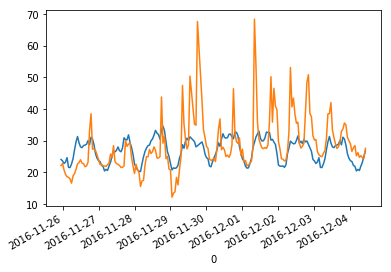

In [144]:
baseline.predict(indep_test.index)[:200].plot()
indep_test[:200].plot()

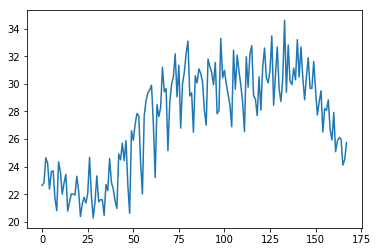

In [145]:
plt.plot(baseline.theta)

In [146]:
# def plot_RMSE_2d(baseline, cost_dict, title):
#     fig = plt.figure(figsize=(8,4))
#     cax = plt.hexbin(*np.array([[*k,np.sqrt(v)] for k, v 
#                           in cost_dict.items() if np.alltrue(np.log10(k) > -8)]).T,
#                      xscale='log',
#                      yscale='log',
#               gridsize=10)
#     axc = fig.colorbar(cax, ax=fig.gca(), shrink=.7)
#     plt.loglog(*baseline.best_lambda, 'ro', markersize=10)
#     plt.xlabel('$λ_1$')
#     plt.ylabel('$λ_2$')
#     plt.title(title)
    
# plot_RMSE_2d(baseline, baseline.val_costs, 'RMSE validation set')


In [147]:
baseline.best_lambda

(0.00046415888336127773, 0.0035938136638046258)

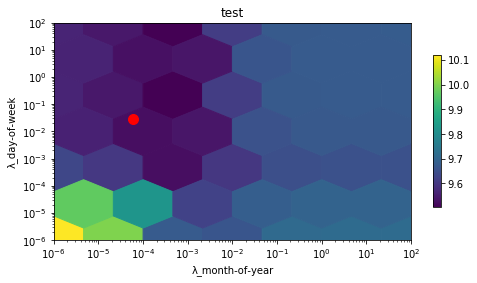

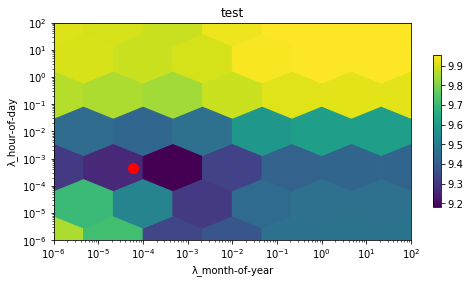

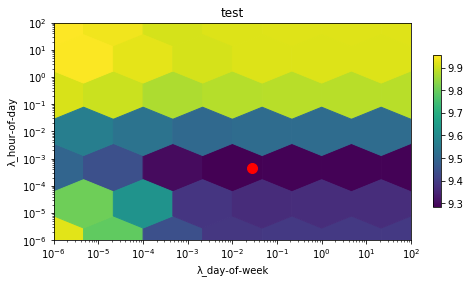

In [140]:
import matplotlib.pyplot as plt

def plot_RMSE_3d(baseline):
    ref = ['month-of-year', 'day-of-week', 'hour-of-day']
    for pat in [[0,1], [0,2], [1,2]]:
        for cost_dict, title in [[baseline.val_costs, 'test']]:#,
                                 #[baseline.tr_costs, 'train']]:
            fig = plt.figure(figsize=(8,4))
            cax = plt.hexbin(*np.array([[*(np.array(k)[pat]), np.sqrt(v)] for k, v 
                                  in cost_dict.items()]).T,
                             xscale='log',yscale='log',
                      gridsize=6)
            axc = fig.colorbar(cax, ax=fig.gca(), shrink=.7)
            plt.loglog(*np.array(baseline.best_lambda)[pat], 'ro', markersize=10)
            plt.xlabel(f'λ_{ref[pat[0]]}')
            plt.ylabel(f'λ_{ref[pat[1]]}')
            plt.title(title)

plot_RMSE_3d(baseline)

Text(0.5,0,'day-of-week')

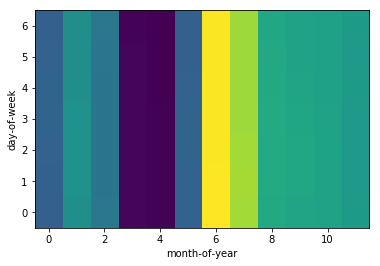

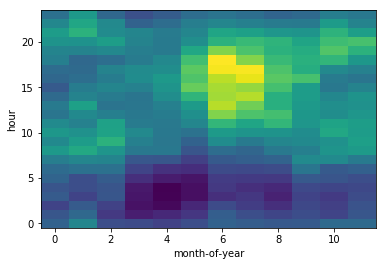

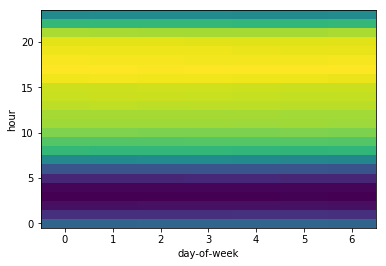

In [141]:
plt.figure()
plt.imshow(np.mean(baseline.theta.reshape(*reversed(baseline.n_periods)),0), 
           origin='lower', aspect='auto')
plt.ylabel('day-of-week')
plt.xlabel('month-of-year')

plt.figure()
plt.imshow(np.mean(baseline.theta.reshape(*reversed(baseline.n_periods)),1), 
           origin='lower', aspect='auto')
plt.ylabel('hour')
plt.xlabel('month-of-year')

plt.figure()
plt.imshow(np.mean(baseline.theta.reshape(*reversed(baseline.n_periods)),2), 
           origin='lower', aspect='auto')
plt.ylabel('hour')
plt.xlabel('day-of-week')

In [195]:
res = test-baseline.predict(test.index)

In [196]:
np.sqrt(np.mean(res**2))

8.0388800734611578

In [191]:
np.sqrt(np.mean((test-train.mean())**2))

8.9727821975641007

In [130]:
fig = plt.figure()#figsize=FIGWIDE)
cax = plt.imshow(baseline.theta.reshape(24, 366), origin='lower', aspect='auto')
#plt.title('$b$')
axc = fig.colorbar(cax, ax=fig.gca(), shrink=.7)
cax.axes.set_xlabel('Day-of-year', size='large')
cax.axes.set_ylabel('Hour', size='large')
axc.ax.set_ylabel('$ per MWh')
#plt.savefig(GRAPHDIR+'norcal_baseline.pdf')

ValueError: cannot reshape array of size 61488 into shape (24,366)

In [90]:
# train = PGE_loads[(PGE_loads.index<"2015-01-01")]
# validation = PGE_loads[(PGE_loads.index>="2015-01-01")&(PGE_loads.index<"2016-01-01")]
# test = PGE_loads[(PGE_loads.index>="2016-01-01")&(PGE_loads.index<"2017-01-01")]
# test = test[~((test.index.month==2)&(test.index.day==29))]

# fig, (ax1, ax2, ax3) = plt.subplots(3,1,figsize=FIGBIG)
# cax = ax1.imshow(train.values.reshape(365,24).T, origin='lower',aspect='auto')
# _ = ax1.set_title('2014')
# _ = ax2.imshow(validation.values.reshape(365,24).T, origin='lower',aspect='auto')
# _ = ax2.set_title('2015')
# _ = ax3.imshow(test.values.reshape(365,24).T, origin='lower',aspect='auto')
# _ = ax3.set_title('2016')
# _ = ax3.set_xlabel('Day')
# _ = ax1.set_ylabel('Hour')
# _ = ax2.set_ylabel('Hour')
# _ = ax3.set_ylabel('Hour')
# axc = fig.colorbar(cax, ax=[ax1, ax2, ax3], shrink=.6)
# axc.ax.set_ylabel('MW')
# plt.savefig(GRAPHDIR+'norcal_loads_2d.pdf')

In [20]:
indexers = lambda index: index.hour, \
        lambda index: index.dayofyear-1,\

n_periods =  24, 366
lambdas = [[.01, .02, .05, .1, .2, .5, 1., 2., 5., 10., 20.],
          [10., 20., 50.]]

b, val_rmse, indexer = smooth_cyclic_baseline(pd.concat([train,validation]), 
                                     indexers, n_periods,
                                     lambdas, train_fraction = .75)

We have 17520 observations.
Fitting baseline with 8784 = 24*366 values.
Building block diag. with 366 blocks.
Building matrix of size 24 with diff 1.
Building block diag. with 1 blocks.
Building matrix of size 8784 with diff 24.
Solving for 33 combinations of lambdas.
Best lambdas are (0.5, 10.0), with validation RMSE 781.42.
Fitting with all data.


In [21]:
val_rmse_df = pd.DataFrame()
val_rmse_df.columns.name = '$\lambda_{diu}$'
val_rmse_df.index.name = '$\lambda_{smooth}$'
for lambdas_used in val_rmse:
    val_rmse_df.loc[lambdas_used] = val_rmse[lambdas_used]
#val_rmse_df

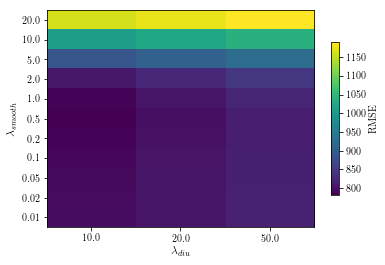

In [22]:
fig = plt.figure(figsize=FIGREGULAR)
cax = plt.imshow(val_rmse_df, origin='lower', aspect='auto')
cax.axes.set_xlabel('$\lambda_{diu}$', size='large')
cax.axes.set_ylabel('$\lambda_{smooth}$', size='large')
plt.yticks(np.arange(len(lambdas[0])), lambdas[0])
plt.xticks(np.arange(len(lambdas[1])), lambdas[1])
# colorbar
axc = fig.colorbar(cax, ax=fig.gca(), shrink=.7)
axc.ax.set_ylabel('RMSE')

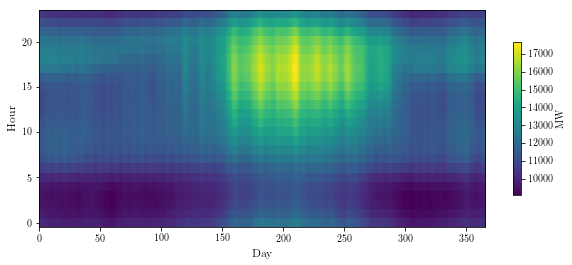

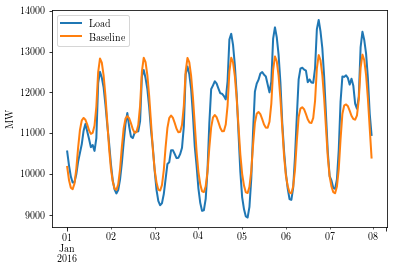

In [23]:
fig = plt.figure(figsize=FIGWIDE)
cax = plt.imshow(b.reshape(366, 24).T, origin='lower', aspect='auto')
#plt.title('$b$')
axc = fig.colorbar(cax, ax=fig.gca(), shrink=.7)
cax.axes.set_xlabel('Day', size='large')
cax.axes.set_ylabel('Hour', size='large')
axc.ax.set_ylabel('MW')
plt.savefig(GRAPHDIR+'norcal_baseline.pdf')


plot_index = test.iloc[:24*7].index
fig=plt.figure(figsize=FIGREGULAR)
test[plot_index].plot(label='Load')
pd.Series(data=b[indexer(plot_index)],
         index = plot_index).plot(label='Baseline')
fig.gca().set_ylabel('MW')
plt.legend()
plt.savefig(GRAPHDIR+'norcal_loads.pdf')

### Diagnostic 

(0, 768)

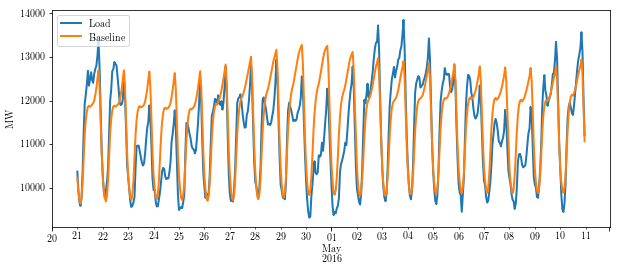

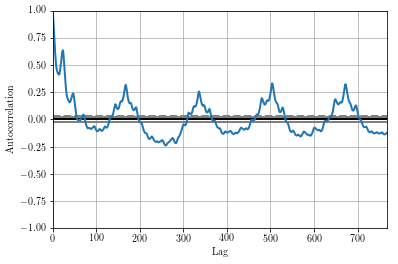

In [14]:
plot_index = test.iloc[24*110:24*130].index
fig=plt.figure(figsize=FIGWIDE)
test[plot_index].plot(label='Load')
pd.Series(data=b[indexer(plot_index)],
         index = plot_index).plot(label='Baseline')
fig.gca().set_ylabel('MW')
plt.legend()
#plt.savefig(GRAPHDIR+'norcal_loads_week.pdf')

test_residuals = test - b[indexer(test.index)]
from pandas.plotting import autocorrelation_plot
plt.figure()
autocorrelation_plot(test_residuals)
plt.xlim([0,24*32])

## Month/week fit 

In [24]:
indexers = lambda index: index.hour, \
    lambda index: index.month-1,\
    lambda index: index.dayofweek,

n_periods =  24, 12, 7
#lambdas = [[.01, .02, .05, .1, .2, .5, 1., 2., 5., 10., 20.]]*3
lambdas = [[.01, .02, .05, .1, .2, .5, 1.,2.]]*3


b, val_rmse, indexer = smooth_cyclic_baseline(pd.concat([train,validation]), 
                                     indexers, n_periods,
                                     lambdas, train_fraction = .75)

We have 17520 observations.
Fitting baseline with 2016 = 24*12*7 values.
Building block diag. with 84 blocks.
Building matrix of size 24 with diff 1.
Building block diag. with 7 blocks.
Building matrix of size 288 with diff 24.
Building block diag. with 1 blocks.
Building matrix of size 2016 with diff 288.
Solving for 512 combinations of lambdas.
Best lambdas are (0.5, 0.05, 0.02), with validation RMSE 697.75.
Fitting with all data.


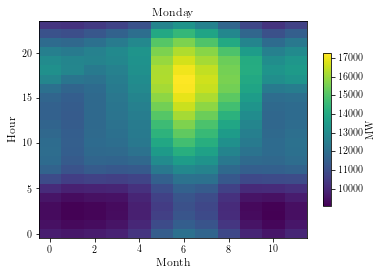

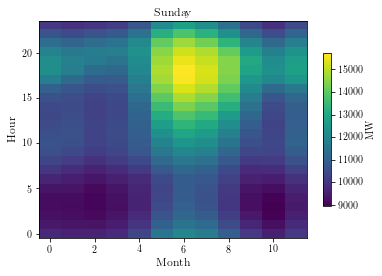

In [16]:
fig = plt.figure(figsize=FIGREGULAR)
cax = plt.imshow(b[:288].reshape(12, 24).T, origin='lower', aspect='auto')
plt.title('Monday', size='large')
axc = fig.colorbar(cax, ax=fig.gca(), shrink=.7)
cax.axes.set_xlabel('Month', size='large')
cax.axes.set_ylabel('Hour', size='large')
axc.ax.set_ylabel('MW')

fig = plt.figure(figsize=FIGREGULAR)
plt.title('Sunday', size='large')
cax = plt.imshow(b[-288:].reshape(12, 24).T, origin='lower', aspect='auto')
#plt.title('$b$')
axc = fig.colorbar(cax, ax=fig.gca(), shrink=.7)
cax.axes.set_xlabel('Month', size='large')
cax.axes.set_ylabel('Hour', size='large')
axc.ax.set_ylabel('MW')
#plt.savefig(GRAPHDIR+'norcal_baseline.pdf')

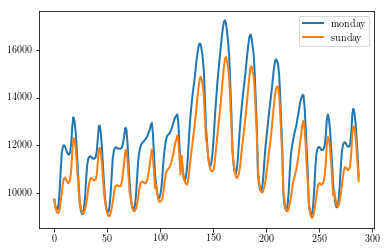

In [18]:
plt.plot(b[:288],label='monday')
#plt.plot(b[-288*3:-288*2])
#plt.plot(b[-288*2:-288])
plt.plot(b[-288:],label='sunday')
plt.legend()

### Diagnostic

(0, 768)

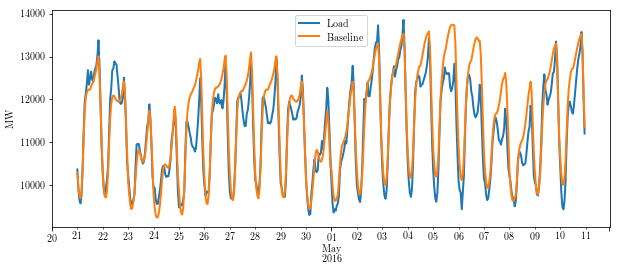

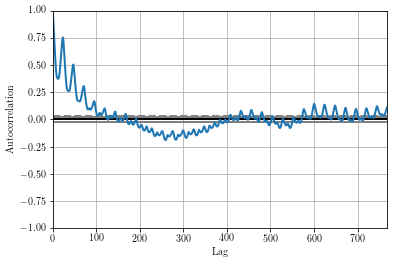

In [25]:
plot_index = test.iloc[24*110:24*130].index
fig=plt.figure(figsize=FIGWIDE)
test[plot_index].plot(label='Load')
pd.Series(data=b[indexer(plot_index)],
         index = plot_index).plot(label='Baseline')
fig.gca().set_ylabel('MW')
plt.legend()
#plt.savefig(GRAPHDIR+'norcal_loads_week.pdf')

test_residuals = test - b[indexer(test.index)]
from pandas.plotting import autocorrelation_plot
plt.figure()
autocorrelation_plot(test_residuals)
plt.xlim([0,24*32])

## Old 

In [ ]:
# residuals = []

# K = 10
# steps = np.zeros((N,K))
# xs = np.zeros((N,K))

# Q = np.ones((K+1, K+1))
# p = np.concatenate([np.zeros(K),[1.]])
# Q[-1,-1] = 0.

# # Anderson acceleration
# def Anderson(steps, xs, i, K):
#     if i <= K:
#         return x
#     Q[:K,:K] = 2 * steps.T@steps
#     return xs @ np.linalg.solve(Q, p)[:-1]

# import time
# start = time.time()
# for i in range(5000):
#     x = Anderson(steps, xs, i, K)
#     step = AAT @ x - Ab
#     x -= lambda_step * step
#     steps[:,i%K] = step
#     xs[:,i%K] = x
#     residuals.append(np.sqrt(np.mean(step**2)))
#     if residuals[-1] < 1E-5:
#         break
# print (time.time() - start)

# plt.semilogy(residuals)

Anderson with K=25 takes about 40s, 2500 iters, to get to 1E-5 residual avg.

Anderson with K=10 takes about 25s, 3300 iters, to get to 1E-5 residual avg.

Anderson with K=7 takes about 22s, 4000 iters, to get to 1E-5 residual avg.

Anderson with K=5 takes about 14s, 3500 iters, to get to 1E-5 residual avg.

In [ ]:
# import cvxpy as cvx

# days, times = windpow_2011.shape
# baseline = cvx.Variable(days, times)

# objective = cvx.sum_squares(baseline - windpow_2011.as_matrix()) #+ \
#    # cvx.sum_squares(baseline - windpow_2012.as_matrix())

# lambda_time = 30.
# objective += lambda_time * cvx.sum_squares(baseline[:,:-1] - baseline[:,1:])
# objective += lambda_time * cvx.sum_squares(baseline[:,-1] - baseline[:,0])

# lambda_date = 100.
# objective += lambda_date * cvx.sum_squares(baseline[:-1,:] - baseline[1:,:])
# objective += lambda_date * cvx.sum_squares(baseline[-1,:] - baseline[0,:])


# problem = cvx.Problem(cvx.Minimize(objective), [])
# #problem.solve(solver=cvx.LS, verbose=True)
# problem.solve(solver=cvx.SCS, verbose=True, use_indirect=True, 
#               acceleration_lookback = 25, max_iters = 2000)